# Optical - CMB Cross-Correlation

### Colin Hill and Jeff McMahon and Renée Hložek

## First we read in the necessary libraries.

In [10]:
import numpy as np
import matplotlib
import sys
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import astropy.io.fits as fits


%matplotlib inline
import constants as cs # the constants module

from cmb_modules import * # the module of functions

N = cs.N
N_iterations = cs.N_iterations
c_min = cs.c_min
c_max = cs.c_max
X_width =cs.X_width
Y_width = cs.Y_width
beam_size_fwhp = cs.beam_size_fwhp

pix_size = cs.pix_size

Number_of_Sources  = cs.Number_of_Sources
Amplitude_of_Sources = cs.Amplitude_of_Sources
Number_of_Sources_EX = cs.Number_of_Sources_EX
Amplitude_of_Sources_EX = cs.Amplitude_of_Sources_EX

Number_of_SZ_Clusters  = cs.Number_of_SZ_Clusters
Mean_Amplitude_of_SZ_Clusters = cs.Mean_Amplitude_of_SZ_Clusters
SZ_beta = cs.SZ_beta
SZ_Theta_core = cs.SZ_Theta_core

white_noise_level = cs.white_noise_level
atmospheric_noise_level = 0#cs.atmospheric_noise_level
one_over_f_noise_level = 0#cs.one_over_f_noise_level

### rebuildng the simulated map from previous excercises

Number of sources required:  5000
map mean: -26.07003074201684 map rms: 106.73771589746549


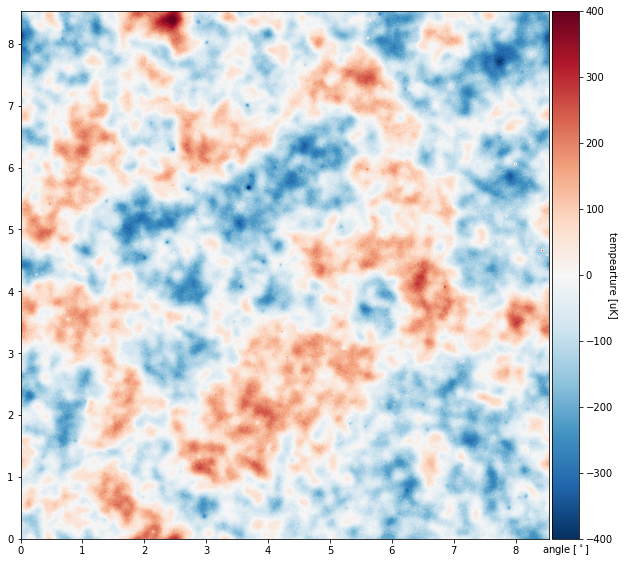

In [11]:
## Make a CMB map
ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True) 
CMB_T = make_CMB_T_map(N,pix_size,ell,DlTT)

N=int(N)
## make a point source map
PSMap = Poisson_source_component(N,pix_size,Number_of_Sources,Amplitude_of_Sources) 
PSMap +=  Exponential_source_component(N,pix_size,Number_of_Sources_EX,Amplitude_of_Sources_EX)

## make an SZ map
SZMap,SZCat = SZ_source_component(N,pix_size,Number_of_SZ_Clusters,Mean_Amplitude_of_SZ_Clusters,SZ_beta,SZ_Theta_core,False)

## add them all together to get the sky map at a single freuqency
total_map = CMB_T + PSMap + SZMap

## incorperate the impact of the instrument
    ## beam
CMB_T_convolved =convolve_map_with_gaussian_beam(N,pix_size,beam_size_fwhp,total_map)
    ## noise
Noise = make_noise_map(N,pix_size,white_noise_level,atmospheric_noise_level,one_over_f_noise_level)

total_map_plus_noise = CMB_T_convolved + Noise

total_map_plus_noise_original = total_map_plus_noise
SZCat_original = SZCat
## plot the result
p=Plot_CMB_Map(total_map_plus_noise,c_min,c_max,X_width,Y_width)

## we will need a window funciton below, so we creat that here
window = (cosine_window(N))

## Cross-correlation of Optical and CMB Maps

An alternative to real-space stacking is Fourier-space cross-correlation.  For example one can take an optical catalogue, make a map in the same pixelization as the CMB map of the density of sources (or sum of the masses or other property), smooth that map and take the power spectrum using the techniques we used for CMB analysis.  One can furthermore take the cross-power spectrum of this map with the CMB map (or potentially a component-separated map or a lensing map, which would isolate the signal of interest for the cross-correlation).

Let's make a simple mock optical galaxy map that is correlated with the thermal SZ signal in our CMB map (which we generated in Part 02), and then measure the cross-power spectrum to detect the tSZ - galaxy number density cross-correlation.

A common way to model the distribution of galaxies in the universe is the "Halo Occupation Distribution" (HOD) formalism.  In the HOD approach, one assigns galaxies to dark matter halos as a function of the halo mass, redshift, and/or other properties.  One complexity is that there are two sub-populations of galaxies to consider: (1) central galaxies, of which there is at most one in each halo (usually located at or near the "center" of the halo), and which is typically by far the largest and brightest galaxy in that halo; (2) satellite galaxies, of which there can be many in each halo, and which are distributed in some fashion around the central galaxy within the halo.

A popular HOD model is that of Zheng et al. (2007), which models the number of central galaxies ($N_c$) and satellite galaxies ($N_s$) as follows (note that here the model only depends on halo mass $M$, but in general such expressions could depend on redshift or other quantities):
$$
N_c(M) = \frac{1}{2}\left[1+\mathrm{erf}\left(\frac{\log M - \log M_\mathrm{min}}{\sqrt{2}\sigma_{\log M}}\right)\right]
$$
and
$$
N_s(M) = N_c(M) \left[ \frac{M-M_0}{M'_1} \right]^{\alpha_s}
$$
where the HOD parameters are $M_\mathrm{min}$, $\sigma_{\log M}$, $\alpha_s$, $M_0$, $M'_1$, and erf is the error function $\mathrm{erf}(x)=\frac{2}{\sqrt{\pi}} \int_{0}^{x} e^{-t^2} dt$.  Intuitively, $M_\mathrm{min}$ sets the minimum halo mass required to host a central galaxy and $\sigma_{\log M}$ sets the width of the "transition" between halos hosting zero central galaxies and those hosting one.  (Note that non-integer values of $N_c$ can be thought of as a fraction of halos of that mass hosting a central galaxy.)  Similarly, $M_0$, $M'_1$, and $\alpha_s$ determine the dependence of the number of satellite galaxies on halo mass, with larger values of $\alpha_s$ leading to a steeper increase in $N_s$ at high halo masses.

<font color='red'>EXCERCISE: </font>  Plot $N_c(M)$ and $N_s(M)$ and explore their dependence on the HOD parameters.  Note that a typical value of $M_{\rm min}$ might be $5 \times 10^{12} M_{\odot}$.  Generally these values depend on the exact galaxy sample under consideration.


In [12]:
from scipy.special import erf

## your code goes here

To connect this HOD model with our simple SZ simulation code from Part 02, let's rephrase the HOD in terms of the cluster SZ amplitude (this would not be done in a real data analysis, but it will make our lives easier here, and this quantity is connected to the halo mass).  We'll simply replace $M$ with the SZ cluster amplitude $A_{SZ}$ in the above equations, and make judicious choices for the HOD parameters to accommodate this, i.e.:
$$
N_c(A_{SZ}) = \frac{1}{2}\left[1+\mathrm{erf}\left(\frac{\log A_{SZ} - \log A_{SZ,\mathrm{min}}}{\sqrt{2}\sigma_{\log A_{SZ}}}\right)\right]
$$
and
$$
N_s(A_{SZ}) = N_c(A_{SZ}) \left[ \frac{A_{SZ}-A_{SZ,0}}{A_{SZ,1}'} \right]^{\alpha_s}
$$

Let's set $A_{SZ,{\rm min}} = 5$, $\sigma_{\log A_{SZ}} = 1$, $A_{SZ,0} = 0$, $A_{SZ,1}' = 5$, and $\alpha_s = 1.5$.

The last ingredient we need to complete the model is a specification of the spatial distribution of satellite galaxies in each halo.  For simplicity, let's assume the satellites follow a beta profile (like the SZ), but with a more compact profile than the SZ signal.  (A beta model is not very accurate for describing satellite distributions, but it is true that the galaxy distribution tends to be more compact than the gas.)

We'll combine this simple model with our SZ simulation code from Part 02 to generate a simulated galaxy number density map.  To make things easier, let's not worry too much about the physical meaning of fractional galaxy numbers here.

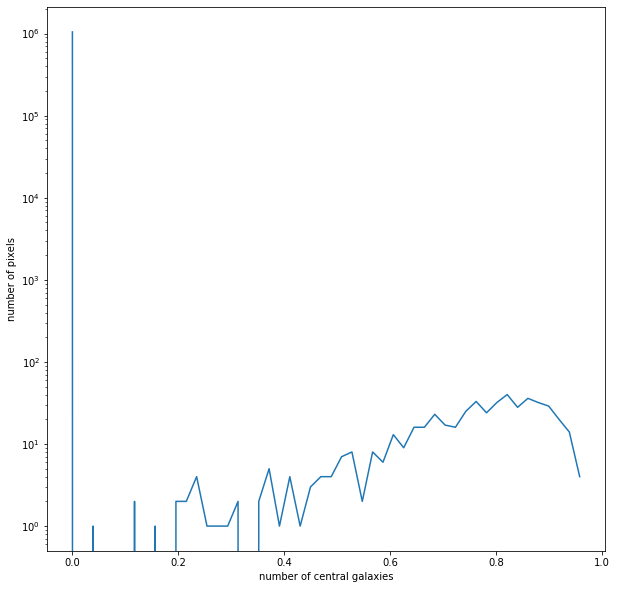

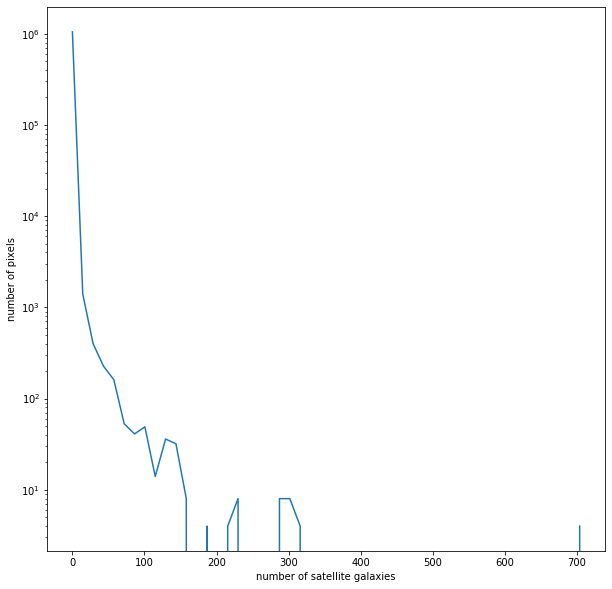

map mean: 0.00035702602540102274 map rms: 0.01673802111886781


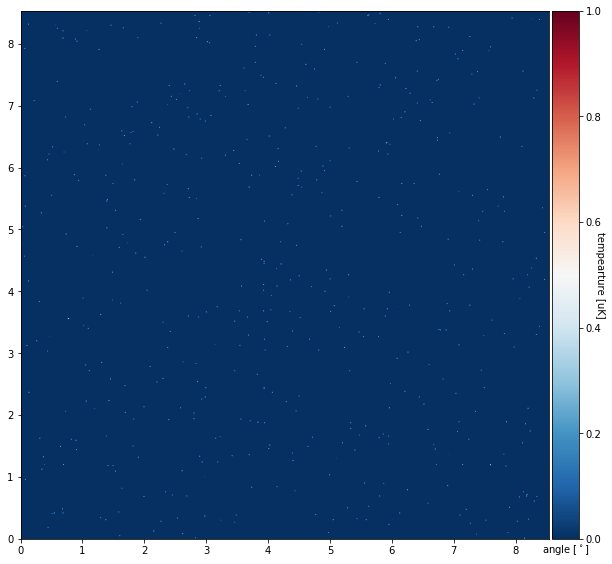

map mean: 0.20465213245463337 map rms: 3.1650176303602047


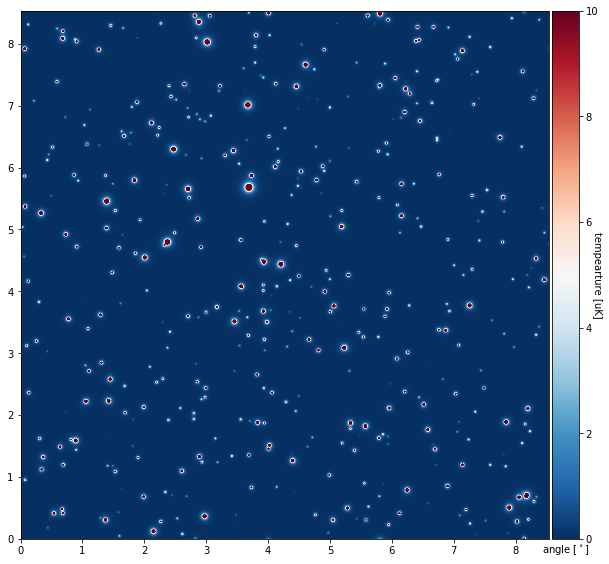

map mean: 0.20500915848003445 map rms: 3.168663065749511


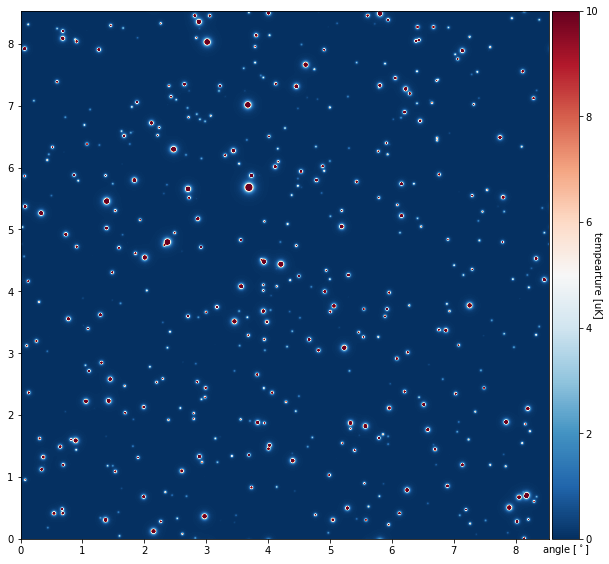

map mean: -13.434202483786946 map rms: 7.233077493822275


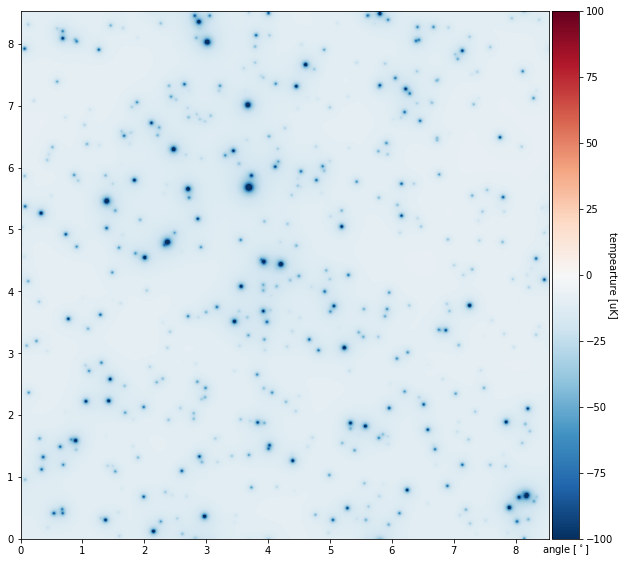

In [13]:
### parameters to set up the galaxy map
# Note: we will use SZCat from above to ensure that the cluster locations used here match those from the SZ map

satgal_beta = 1.4 #more compact (larger beta) than SZ in notebook 02
satgal_Theta_core = 0.75 #more compact (smaller theta_core) than SZ in notebook 02

def N_c(A_SZ, A_SZmin, sigma_logASZ):
    return 0.5*(1. + erf( (np.log10(A_SZ)-np.log10(A_SZmin))/(np.sqrt(2.)*sigma_logASZ) ))

def N_s(A_SZ, A_SZ0, Ap_SZ1, alpha_s, A_SZmin, sigma_logASZ):
    return N_c(A_SZ, A_SZmin, sigma_logASZ) * ((A_SZ-A_SZ0)/Ap_SZ1)**alpha_s

A_SZmin = 5.
sigma_logASZ = 1.
A_SZ0 = 0.
Ap_SZ1 = 5.
alpha_s = 1.5


def galaxy_component(N,pix_size,SZCat,satgal_beta,satgal_Theta_core,do_plots):
    "makes a realization of a naive galaxy number density map associated with the locations of SZ clusters"
    N=int(N)
    Number_of_SZ_Clusters = len(SZCat[0])
    CentGalMap = np.zeros([N,N]) # central galaxy map
    SatGalMap = np.zeros([N,N]) # satellite galaxy map -- need to treat separately as these have a profile
    GalMap = np.zeros([N,N]) # central+satellite galaxy map
    CentGalcat = np.zeros([3,Number_of_SZ_Clusters]) ## catalogue of SZ clusters, X, Y, amplitude
    SatGalcat = np.zeros([3,Number_of_SZ_Clusters]) ## catalogue of SZ clusters, X, Y, amplitude
    # use our existing distribution of SZ sources with varying amplitude
    i = 0
    while (i < Number_of_SZ_Clusters):
        pix_x = SZCat[0,i] #int(N*np.random.rand())
        pix_y = SZCat[1,i] #int(N*np.random.rand())
        pix_amplitude = SZCat[2,i] #np.random.exponential(Mean_Amplitude_of_SZ_Clusters)*(-1.)
        # centrals
        CentGalcat[0,i] = int(pix_x)
        CentGalcat[1,i] = int(pix_y)
        CentGalcat[2,i] = N_c(-1.*pix_amplitude, A_SZmin, sigma_logASZ)
        CentGalMap[int(pix_x),int(pix_y)] += CentGalcat[2,i]
        # satellites
        SatGalcat[0,i] = int(pix_x)
        SatGalcat[1,i] = int(pix_y)
        SatGalcat[2,i] = N_s(-1.*pix_amplitude, A_SZ0, Ap_SZ1, alpha_s, A_SZmin, sigma_logASZ)
        #print(-1.*pix_amplitude, CentGalcat[2,i], SatGalcat[2,i])
        SatGalMap[int(pix_x),int(pix_y)] += SatGalcat[2,i]
        i = i + 1
    if (do_plots):
        hist,bin_edges = np.histogram(CentGalMap,bins = 50,range=[CentGalMap.min(),CentGalMap.max()])
        plt.figure(figsize=(10,10))
        plt.semilogy(bin_edges[0:-1],hist)
        plt.xlabel('number of central galaxies')
        plt.ylabel('number of pixels')
        plt.show()      
    
    # make a beta function for the satellite galaxy distributions
    beta = beta_function(int(N),pix_size,satgal_beta,satgal_Theta_core)
    
    # convolve the beta function with the map of satellite galaxy number to get the satellite galaxy map
    # NOTE: you should go back to the Intro workshop for more practice with convolutions!
    FT_beta = np.fft.fft2(np.fft.fftshift(beta))
    FT_SatGalMap = np.fft.fft2(np.fft.fftshift(SatGalMap))
    SatGalMap = np.fft.fftshift(np.real(np.fft.ifft2(FT_beta*FT_SatGalMap)))
    
    if (do_plots):
        hist,bin_edges = np.histogram(SatGalMap,bins = 50,range=[SatGalMap.min(),SatGalMap.max()])
        plt.figure(figsize=(10,10))
        plt.semilogy(bin_edges[0:-1],hist)
        plt.xlabel('number of satellite galaxies')
        plt.ylabel('number of pixels')
        plt.show()  
    
    # return the total galaxy number map, central galaxy number map, and satellite galaxy number map
    GalMap = CentGalMap + SatGalMap
    return(GalMap,CentGalMap,SatGalMap,CentGalcat,SatGalcat)    
  ############################### 

def beta_function(N,pix_size,SZ_beta,SZ_Theta_core):
  # make a beta function

    N=int(N)
    ones = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.) * pix_size
    X = np.outer(ones,inds)
    Y = np.transpose(X)
    # compute the same real-space R function as before for the PS
    R = np.sqrt(X**2. + Y**2.)
    
    beta = (1 + (R/SZ_Theta_core)**2.)**((1-3.*SZ_beta)/2.)

    # return the beta function map
    return(beta)
  ############################### 
    
## make a galaxy map
GalMap,CentGalMap,SatGalMap,CentGalcat,SatGalcat = galaxy_component(N,pix_size,SZCat,satgal_beta,satgal_Theta_core,True)

# centrals
p=Plot_CMB_Map(CentGalMap,0.,1.,X_width,Y_width)

# satellites
p=Plot_CMB_Map(SatGalMap,0.,10.,X_width,Y_width)

# total
p=Plot_CMB_Map(GalMap,0.,10.,X_width,Y_width)

p=Plot_CMB_Map(SZMap,-100.,100.,X_width,Y_width)


<font color='red'>EXCERCISE: </font>  As noted in Part 02, in reality the cluster radii vary from cluster to cluster.  Following your work in that notebook, enhance the realism of your galaxy number map by making separate maps for each of the different cluster samples that you generated in Part 02.  Combine them all into a single galaxy number map at the end.

In [14]:
## your code here

There is one final step to take before we cross-correlate our galaxy map with our CMB map.  Conventionally, in cosmology we work with the *galaxy overdensity* field, which is the quantity most directly related to theory.  Given a map $n_g(\hat{n})$ of the number of galaxies in each direction $\hat{n}$ on the sky (i.e., in each pixel), the overdensity map is defined as
$$
\delta_g(\hat{n}) \equiv \frac{n_g(\hat{n}) - \bar{n}_g}{\bar{n}_g}
$$
where $\bar{n}_g$ is the mean number of galaxies in the original map.

Thus pixels that have no galaxies have a value of $\delta_g(\hat{n}) = -1$ in the overdensity map.

<font color='red'>EXCERCISE: </font> Convert your galaxy number map into a galaxy overdensity map.  Before we cross-correlate the galaxy overdensity map with our CMB map, compute the auto-power spectrum of your galaxy overdensity map.  Can you interpret its behavior physically, given our simple models above?

In [15]:
## your code here

Finally, we can cross-correlate our galaxy overdensity map with our CMB map.  The only component in the CMB map that correlates with the galaxy positions is the SZ component.  The other components (CMB, point sources, etc) will simply add noise to the cross-correlation.  (In fact, if we had multifrequency CMB information, we could use "component separation" techniques to extract an optimal map of the SZ component alone, which would yield a higher signal-to-noise cross-correlation.)

<font color='red'>EXCERCISE: </font> Use 'calculate_2d_spectrum' from Part 04 to compute the cross-power spectrum of your CMB map with your galaxy overdensity map.  (Conveniently, we already wrote this function such that it is easy to input two maps rather than one.)  Remember to apply the window function to both maps before computing the cross-power spectrum.  Do you obtain a positive or negative cross-power spectrum?  Why?

In [16]:
## your code here

We would also like to have error bars on our cross-power spectrum measurement.  We can use a simple analytic formula:
$$
\sigma^2(C_\ell^{AB}) = \frac{1}{(2\ell+1)f_{\rm sky} \Delta_\ell} \left( C_\ell^{AA} C_\ell^{BB} + (C_\ell^{AB})^2 \right)
$$

Here, $A$ and $B$ are the two fields being cross-correlated, with $AB$ labeling the cross-power spectrum and $AA$ and $BB$ the auto-power spectra, and $f_{\rm sky}$ is the sky fraction used for the measurement.  Note that you can easily compute $f_{\rm sky}$ using the dimensions of our map, X_width and Y_width, and the pixel size pix_size (to be clear, $f_{\rm sky}$ is the area of our map in e.g. square degrees divided by the total area of the full sky in square degrees).  We assume that the power spectra have been measured in multipole bins of width $\Delta_{\ell}$ (you can use $\Delta_\ell = 1$ here for simplicity).

<font color='red'>EXCERCISE: </font> Compute the error bars on your cross-power spectrum measurement and include them on a plot.  Estimate the S/N of your cross-power spectrum detection.  How could the S/N be improved?

In [17]:
## your code here

You are now ready to fit theoretical models to cross-correlation measurements!  In this case, we have simulated and measured the thermal SZ - galaxy number density cross-correlation.  We could also consider cross-correlations of CMB lensing maps with galaxy number density, or similar cross-correlations with galaxy weak lensing maps.  See further examples in https://github.com/ACTCollaboration/DR4_DR5_Notebooks/blob/master/Notebooks/Section_5_Lensing_maps.ipynb .

A number of theory codes exist for interpreting such measurements, including CLASS_SZ (https://github.com/borisbolliet/class_sz), hmvec (https://github.com/simonsobs/hmvec), and CCL (https://github.com/LSSTDESC/CCL).